<a href="https://colab.research.google.com/github/soft-guy/python/blob/main/data_mining/graph_edit_distance/Graph_Edit_Distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Graph Edit Distance

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import copy

In [2]:
# function for drawing a graph
# we use as labels attributes given by keys
def draw_graph(g, node_labels_key=None):
  pos = nx.circular_layout(g)
  nx.draw_networkx_nodes(g, pos, node_color="yellow")
  if node_labels_key != None:
    nx.draw_networkx_labels(g, pos, labels=nx.get_node_attributes(g, node_labels_key))
  nx.draw_networkx_edges(g, pos, edge_color="red")
  nx.draw_networkx_edge_labels(g, pos, font_color="green" )

In [3]:
# permutations of size n without repetitions
# we assume n <= len(list1)
def permutations_n_wr(list1, n):
  permutations = []
  if(n == 0):
    permutations.append([])
  else:
    for i in range(len(list1)):
      list_copy = copy.copy(list1)
      elem = list_copy.pop(i)
      for permutation in permutations_n_wr(list_copy, n - 1):
        permutations.append([elem] + permutation)
  return permutations


# permutations of size <= n without repetitions
# we assume n <= len(list1)
def permutations_up_to_n_wr(list1, n):

  def local_perm(list_l, n, permutations):
    all_permutations = permutations
    if(n != 0):
      for i in range(len(list_l)):
        new_permutations = []
        list_copy = copy.copy(list_l)
        elem = list_copy.pop(i)
        for perm in permutations:
          new_permutations.append(perm + [elem])
        all_permutations = all_permutations + local_perm(list_copy, n - 1, new_permutations)
    return all_permutations


  return local_perm(list1, n, [[]])


# permutations of size n without repetitions
# we assume n <= len(list1)
def combinations_n_wr(list1, n):

  def comb_local(list1, n):
    combinations = []
    if(n == 0):
      combinations.append([])
    else:
      for i in range(len(list1)):
        elem = list1[i]
        for combination in comb_local(list1[i + 1:], n - 1):
          combinations.append([elem] + combination)
    return combinations


  return {n: comb_local(list1, n)}


# permutations of size <= n without repetitions
# we assume n <= len(list1)
def combinations_up_to_n_wr(list1, n):
  commbinations_ret = {0: [[]]}

  def local_comb(list_l, n, combinations):
    if(n != 0 and len(list_l) != 0):
      length = len(combinations[0]) + 1
      if(commbinations_ret.get(length) == None):
        commbinations_ret[length] = []
      for i in range(len(list_l)):
        new_combinations = []
        elem = list_l[i]
        for comb in combinations:
          new_comb = comb + [elem]
          new_combinations.append(new_comb)
          commbinations_ret[length].append(new_comb)
        local_comb(list_l[i + 1:], n - 1, new_combinations)


  local_comb(list1, n, [[]])

  return commbinations_ret

In [4]:
# graph edit distance function
def graph_edit_distance(g1, g2,\
                        node_subst_cost=10,\
                        node_del_cost=2,\
                        node_ins_cost=3,\
                        edge_subst_cost=4,\
                        edge_del_cost=5,\
                        edge_ins_cost=6):
  
  g1_nodes = list(g1.nodes)
  g2_nodes = list(g2.nodes)

  # all paths that make sence
  # and may correspnd to the graph edit distance are given by
  # bijections between subsets of nodes of each of the graphs
  # moreover, if node_subst_cost <= node_ins_cost + node_del_cost
  # it suffices to consider only bijections of maximum size
  # given by the graph with smaller number of nodes

  # to iterate on bijections we will use permutations for the first graph
  # and combinations for the second
  min_len = min(len(g1_nodes), len(g2_nodes))

  if node_subst_cost > node_del_cost + node_ins_cost:
    graph1_subsets = permutations_up_to_n_wr(g1_nodes, min_len)
    graph2_subsets = combinations_up_to_n_wr(g2_nodes, min_len)
  else:
    graph1_subsets = permutations_n_wr(g1_nodes, min_len)
    graph2_subsets = combinations_n_wr(g2_nodes, min_len)

  min_cost = float("inf")

  for nodes1 in graph1_subsets:
    for nodes2 in graph2_subsets[len(nodes1)]:
      cost = 0
      # nodes we are to delete
      nodes_to_delete = list(set(g1_nodes) - set(nodes1))

      # first we need to delete edges for them
      for i in range(len(nodes_to_delete)):
        # first between nodes we delete and nodes we keep
        for node in nodes1:
          if(g1.has_edge(nodes_to_delete[i], node)):
            cost += edge_del_cost
        # and now between nodes we delete
        for j in range(i + 1, len(nodes_to_delete)):
          if(g1.has_edge(nodes_to_delete[i], nodes_to_delete[j])):
            cost += edge_del_cost
        
      # now we can delete those nodes
      cost += node_del_cost * len(nodes_to_delete)

      # nodes we are to add
      nodes_to_add = list(set(g2_nodes) - set(nodes2))
      cost += node_ins_cost * len(nodes_to_add)

      # now we add edges for nodes we inserted
      for i in range(len(nodes_to_add)):
        # first between nodes we add and nodes we keep
        for node in nodes2:
          if(g2.has_edge(nodes_to_add[i], node)):
            cost += edge_ins_cost
        # and now between nodes we add
        for j in range(i + 1, len(nodes_to_add)):
          if(g2.has_edge(nodes_to_add[i], nodes_to_add[j])):
            cost += edge_ins_cost
      
      # substitute nodes if the corresponding attributes are different
      for i in range(len(nodes1)):
        if g1.nodes[nodes1[i]] != g2.nodes[nodes2[i]]:
          cost += node_subst_cost

      # update edges between the nodes we keep
      for i in range(len(nodes1) - 1):
        for j in range(i + 1, len(nodes1)):
          # first we add edges if there are edges in the target graph 
          # but there is no edge in the source graph
          # for corresponding pairs of edges
          if(g2.has_edge(nodes2[i], nodes2[j]) and (not g1.has_edge(nodes1[i], nodes1[j]))):
            cost += edge_ins_cost 
          # if there is an edge in the source but not in the target
          if((not g2.has_edge(nodes2[i], nodes2[j])) and g1.has_edge(nodes1[i], nodes1[j])):
            cost += edge_del_cost
          # if there are edges in both but labels are different
          if(g2.has_edge(nodes2[i], nodes2[j]) and g1.has_edge(nodes1[i], nodes1[j])\
            and g2[nodes2[i]][nodes2[j]] != g1[nodes1[i]][nodes1[j]]):
            cost += min(edge_subst_cost, edge_del_cost + edge_ins_cost)

      # update min_cost      
      if(cost < min_cost):
        min_cost = cost

  return min_cost

g_1 =


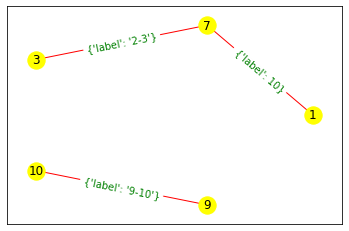

-----------------------------------------------------------------------
g_2 =


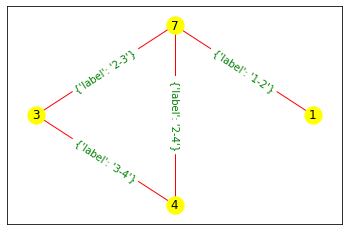

Graph edit distance between g1 and g2 according to my function 'graph_edit_distance' is equal to 28
Graph edit distance between g1 and g2 according to networkx is equal to 28.0
Graph edit distance between g2 and g1 according to my function 'graph_edit_distance' is equal to 28
Graph edit distance between g1 and g2 according to networkx is equal to 28.0


In [5]:
# two graphs g1 and g2
# we use key "label" for all the labels both for nodes and edges
g1 = nx.Graph()
g1.add_nodes_from([
  (1, {"label": "1"}),
  (2, {"label": "7"}),
  (3, {"label": "3"}),
])
g1.add_edges_from([
  (1, 2, {"label": "1-2"}),
  (2, 3, {"label": "2-3"}),
])
g2 = copy.deepcopy(g1)
g2.add_nodes_from([
  (4, {"label": "4"}),
])
g2.add_edges_from([
  (2, 4, {"label": "2-4"}),
  (3, 4, {"label": "3-4"}),  
])
g1.add_node(4, label="10")
g1.add_node(5, label="9")
g1.add_edge(4, 5, label="9-10")
g1[1][2]["label"] = 10


# draw graphs
print("g_1 =")
draw_graph(g1, "label")
plt.show()
print("-----------------------------------------------------------------------")
print("g_2 =")
plt.clf()
draw_graph(g2, "label")
plt.show()


# compare my functon and networkx.graph_edit_distance
print("Graph edit distance between g1 and g2 according to my function",\
      "'graph_edit_distance' is equal to", graph_edit_distance(g1, g2))
print("Graph edit distance between g1 and g2 according to networkx is equal to",\
      nx.graph_edit_distance(g1, g2,\
                             node_subst_cost=lambda x, y: 10 if x != y else 0,\
                             node_del_cost=lambda x: 2,\
                             node_ins_cost=lambda x: 3,\
                             edge_subst_cost=lambda x, y: 4 if x != y else 0,\
                             edge_del_cost=lambda x: 5,\
                             edge_ins_cost=lambda x: 6))
print("Graph edit distance between g2 and g1 according to my function",\
      "'graph_edit_distance' is equal to", graph_edit_distance(g2, g1))
print("Graph edit distance between g1 and g2 according to networkx is equal to",\
      nx.graph_edit_distance(g2, g1,\
                             node_subst_cost=lambda x, y: 10 if x != y else 0,\
                             node_del_cost=lambda x: 2,\
                             node_ins_cost=lambda x: 3,\
                             edge_subst_cost=lambda x, y: 4 if x != y else 0,\
                             edge_del_cost=lambda x: 5,\
                             edge_ins_cost=lambda x: 6))